Part 1

<ipython-input-32-483c2a26afdf>:94: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3041, Accuracy: 724/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303172
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.300481
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.301890
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.306034
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.297616
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.293235
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.288254
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.286482
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.284326
Train Epoch: 1 [9000/60000 (15%)]	Loss: 2.274510
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.275764
Train Epoch: 1 [11000/60000 (18%)]	Loss: 2.269606
Train Epoch: 1 [12000/60000 (20%)]	Loss: 2.268893
Train Epoch: 1 [13000/60000 (22%)]	Loss: 2.257548
Train Epoch: 1 [14000/60000 (23%)]	Loss: 2.255307
Train Epoch: 1 [15000/60000 (25%)]	Loss: 2.235859
Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.241159
Train Epoch: 1 [17000/60000 (28%)]	Loss: 2.226553
Train Epoch: 1 [18000/60000 (30%)]	Loss: 2.200683
Train Epoch: 

Text(0, 0.5, 'Loss')

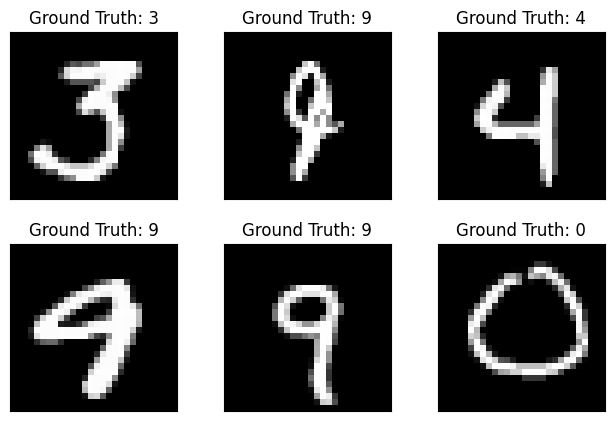

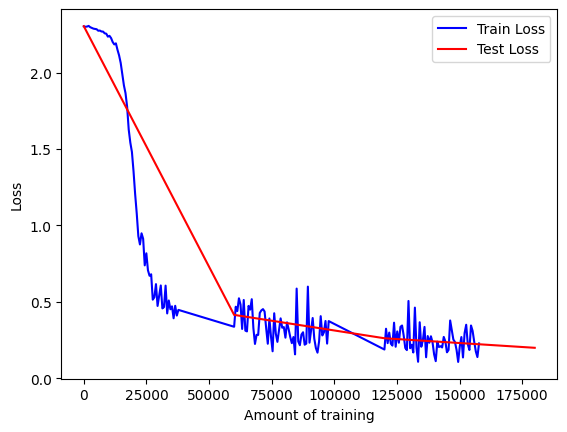

In [ ]:
import time
from __future__ import print_function
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
from torch.utils.tensorboard import SummaryWriter
import argparse
import numpy as np
import matplotlib.pyplot as plt

n_epochs = 3
batch_size_train = 100
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))])), batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=False, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))])), batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

# Model without activation
class nonModel(nn.Module):
    def __init__(self):
        super(nonModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 15)  # Input layer
        self.fc2 = nn.Linear(15, 10)     # Hidden layer
        self.fc3 = nn.Linear(10, 10)     # Output layer

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return F.log_softmax(x)

# Model with ReLU Activation in layers
class actModel(nn.Module):
    def __init__(self):
        super(actModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 15)  # Input layer
        self.fc2 = nn.Linear(15, 12)     # Hidden layer
        self.fc3 = nn.Linear(12, 10)     # Output layer
        self.relu = nn.ReLU()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)

# Deep learning model
class deepModel(nn.Module):
    def __init__(self):
        super(deepModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 250)  # Input layer
        self.fc2 = nn.Linear(250, 300)    # Hidden layer 1
        self.fc3 = nn.Linear(300, 350)    # Hidden layer 2
        self.fc4 = nn.Linear(350, 400)    # Hidden layer 3
        self.fc5 = nn.Linear(400, 10)     # Output layer
        self.relu = nn.ReLU()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return F.log_softmax(x)

# Change this to be whichever class (model) you want
network = deepModel()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

# Training
def train(epoch, train_losses, train_counter):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))


# Testing
def test(test_losses):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

test(test_losses)
for epoch in range(1, n_epochs + 1):
  train(epoch, train_losses, train_counter)
  test(test_losses)

fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Amount of training')
plt.ylabel('Loss')



For each model, the accuracy got better in that order. The simple neural network had good accuracy, but the network with activation functions had a higher accuracy while the network with more layers and activation functions performed around 5% more accurate.

While the training loss did keep decreasing consistently throughout the runtime, it also flucuated during the process.

Runtime of each model was usually around a minute long, with the deep learning model taking a bit longer due to the increase in layers.

Part 2

In [ ]:
# MUST RUN THIS LINE FIRST TO RUN PART 2 CODE
!pip install d2l==0.14.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.5 MB/s eta 0:00:00


Files already downloaded and verified
Files already downloaded and verified


<ipython-input-22-60cb340df1e8>:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3049, Accuracy: 724/10000 (7%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.301336
Train Epoch: 1 [320/50000 (1%)]	Loss: 2.308942
Train Epoch: 1 [640/50000 (1%)]	Loss: 2.313911
Train Epoch: 1 [960/50000 (2%)]	Loss: 2.284858
Train Epoch: 1 [1280/50000 (3%)]	Loss: 2.348626
Train Epoch: 1 [1600/50000 (3%)]	Loss: 2.215584
Train Epoch: 1 [1920/50000 (4%)]	Loss: 2.240091
Train Epoch: 1 [2240/50000 (4%)]	Loss: 2.247228
Train Epoch: 1 [2560/50000 (5%)]	Loss: 2.121577
Train Epoch: 1 [2880/50000 (6%)]	Loss: 2.182862
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.123536
Train Epoch: 1 [3520/50000 (7%)]	Loss: 2.146013
Train Epoch: 1 [3840/50000 (8%)]	Loss: 1.943041
Train Epoch: 1 [4160/50000 (8%)]	Loss: 2.036911
Train Epoch: 1 [4480/50000 (9%)]	Loss: 2.135899
Train Epoch: 1 [4800/50000 (10%)]	Loss: 1.792713
Train Epoch: 1 [5120/50000 (10%)]	Loss: 2.163718
Train Epoch: 1 [5440/50000 (11%)]	Loss: 2.325639
Train Epoch: 1 [5760/50000 (12%)]	Loss: 2.105332
Train Epoch: 1 [6080/50000 (12%)]	

Text(0, 0.5, 'Loss')

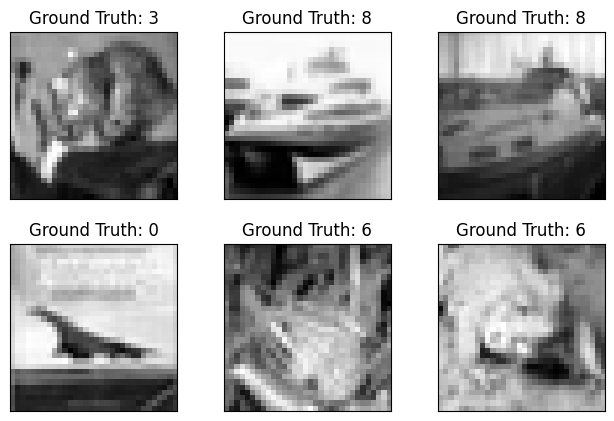

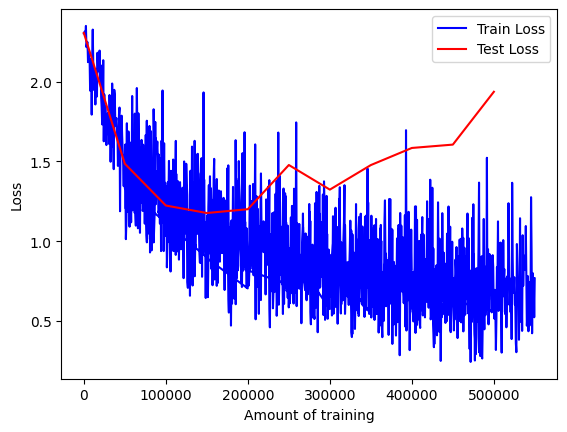

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
import d2l

class convModel(nn.Module):
    def __init__(self):
        super(convModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=3)     # First Conv layer
        nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3)        # Second Conv layer
        nn.ReLU

        self.fc1 = nn.Linear(in_features=1440, out_features=100)                      # Fully connected layer
        self.fc2 = nn.Linear(in_features=100, out_features=10)                      # Fully connected layer

    def forward(self, x):
        x = x

        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = torch.flatten(x, start_dim=1)

        x = x.reshape(-1, 1440)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)

        return F.log_softmax(x)

n_epochs = 10
batch_size_train = 32
batch_size_test = 32
learning_rate = 0.1
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=ToTensor())

train_loader = DataLoader(train_dataset, batch_size=batch_size_train)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

network = convModel()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

# Training
def train(epoch, train_losses, train_counter):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))


# Testing
def test(test_losses):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

test(test_losses)
for epoch in range(1, n_epochs + 1):
  train(epoch, train_losses, train_counter)
  test(test_losses)

fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Amount of training')
plt.ylabel('Loss')

The MNIST network accuracy dropped as the learning rate increased. Time to runtime took around 2-3 minutes.

The CIFAR network accuracy slightly increased from 10-20 epochs, but decreased from 20-30 epochs. The runtime for each part of this task increased as the number of epochs increased. Each runtime, respectivelly was 8-9 mins, 15 mins, and 25-27 mins.